In [125]:
# standard python utilities
import os
import glob
import sys
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio
import landlab

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [3]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))
ghb_dir = gwfm_dir+'/GHB_data'

In [4]:
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

In [5]:
# m_domain = m_domain.to_crs('epsg:3310')

In [6]:
f2013 = gpd.read_file(ghb_dir+'/Fall_2013_Elevation_Points/F2013_WSEL_Points_20150720_090332.shp')
f2013 = f2013.to_crs('epsg:32610')

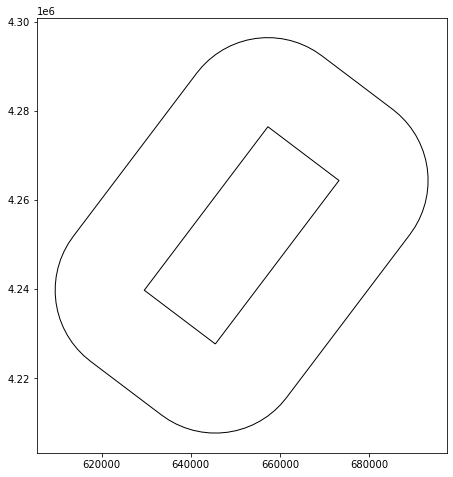

In [7]:
fig,ax= plt.subplots(figsize =(8,8))
m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')
buffer = 2e4
m_domain.buffer(buffer).plot(ax=ax,edgecolor = 'black', color = 'none')

# buffer domain in order to include boundary observations to influence water table elevations at the model edge
domain_buffered = gpd.GeoDataFrame(data = m_domain, geometry = m_domain.buffer(buffer))

<AxesSubplot:>

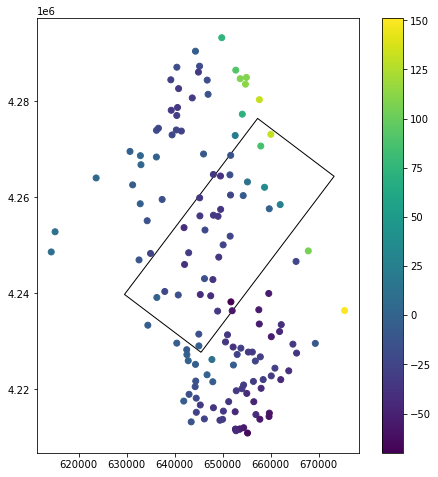

In [8]:
fig,ax= plt.subplots(figsize =(8,8))
m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')

f2013 = gpd.sjoin(f2013,domain_buffered, op = 'within', how = 'inner')
f2013.plot('WSEL', ax=ax, legend = True)

<AxesSubplot:>

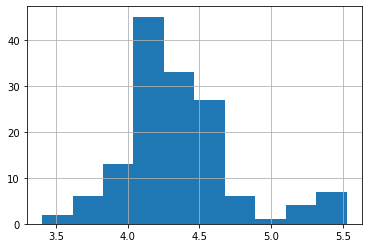

In [9]:
# f2013.WSEL.hist()
# scale by 100 to make all positive values
f2013['logWSEL'] = np.log(f2013.WSEL.values+100)
f2013.logWSEL.hist()

In [10]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from rasterio.transform import Affine


In [160]:
# define function to interpolate/krige water surface elevations
# part 1/2
def lin_krige(filename, domain_buffered, res):
    # filename of shapefiles with water surface elevation points
    # m_domain shapefile to clip grid
    # raster resolution for kriging and output
    
    # Kriging set up
    df = gpd.read_file(filename)
    df = df.to_crs('epsg:32610')
    
    df = gpd.sjoin(df,domain_buffered, op = 'within', how = 'inner')

    x = df.geometry.x.values
    y = df.geometry.y.values
    z = df.WSEL.values
    res = 100
    gridx = np.arange(np.min(x), np.max(x), res)
    gridy = np.arange(np.min(y), np.max(y), res)
    
    # Kriging
    # linear, gaussian, spherical, exponential, hole-effect and power
    OK = OrdinaryKriging(
        x,
        y,
        z,
        variogram_model="linear",
        verbose=True,
        enable_plotting=True,
    #     exact_values = False,
        enable_statistics = True,
        nlags = 50
    )

    
    # z is the kriged grid and ss is the variance grid (sigma ^2)
    z, ss = OK.execute("grid", gridx, gridy)
    # flip data because np sets 0,0 in top left while raster is bottom left
    Z  = np.flip(z.data,axis = 0)
    SS = np.flip(ss.data,axis = 0)
    
    
    # Output file creation
    new_dataset1 = rasterio.open(ghb_dir+'/interpolated_data/' +str(year)+'_kriged.tif',
                           'w',driver = 'GTiff',
                           height=Z.shape[0], width = Z.shape[1],
                           count = 1, dtype = Z.dtype,
                           crs = f2013.crs,
                           transform = transform)

    new_dataset1.write(Z,1)
    new_dataset1.close()

    new_dataset2 = rasterio.open(ghb_dir+'/interpolated_data/' +str(year)+'_variance.tif',
                               'w',driver = 'GTiff',
                               height=Z.shape[0], width = Z.shape[1],
                               count = 1, dtype = Z.dtype,
                               crs = f2013.crs,
                               transform = transform)

    new_dataset2.write(SS,1)
    new_dataset2.close()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.048116054549222485
Nugget: 63.61690132030448 



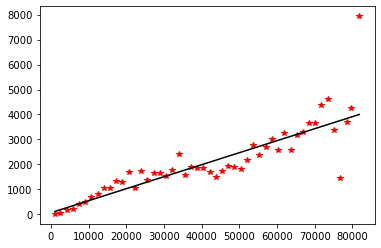

Calculating statistics on variogram model fit...
Q1 = 0.015618731068226449
Q2 = 0.9372777140345642
cR = 277.6199911246673 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.045427368009121206
Nugget: 496.7589052265102 



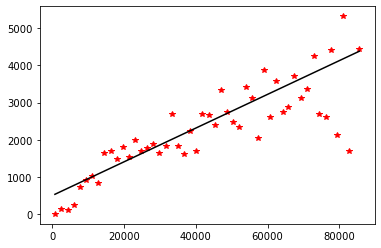

Calculating statistics on variogram model fit...
Q1 = 0.029434101707914568
Q2 = 0.8048765060656338
cR = 737.9953832487266 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.04779283862402568
Nugget: 93.57644368959357 



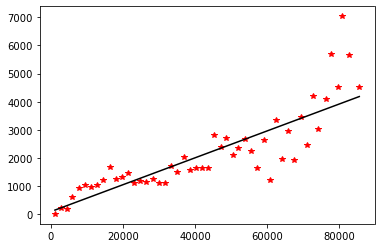

Calculating statistics on variogram model fit...
Q1 = 0.06353612914177914
Q2 = 1.1170538199193976
cR = 454.97923026827135 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11376216242560769
Nugget: 975.5422913736013 



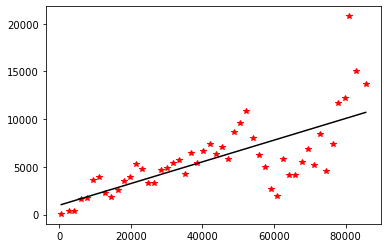

Calculating statistics on variogram model fit...
Q1 = 0.18024951224682004
Q2 = 0.5675996171562847
cR = 1077.6164252689066 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.10566332955133542
Nugget: 1772.9130068510237 



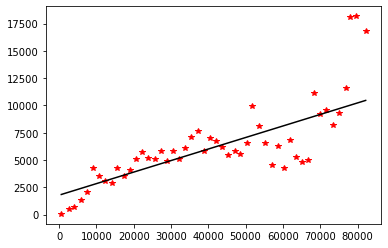

Calculating statistics on variogram model fit...
Q1 = 0.19531150956018767
Q2 = 0.5495138256346995
cR = 1570.3141047882525 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11032031610740932
Nugget: 1826.8364508905288 



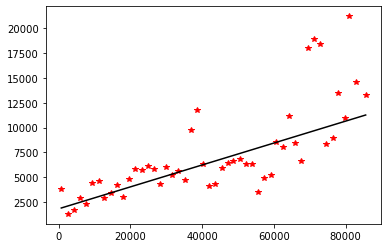

Calculating statistics on variogram model fit...
Q1 = 0.038681588732239876
Q2 = 0.5782299758649001
cR = 1604.9177999168428 

Executing Ordinary Kriging...



In [163]:
strtyear = 2013
endyear = 2019

for year in np.arange(strtyear,endyear):
    filename = glob.glob(ghb_dir+'/Fall_'+str(year)+'_Elevation_Points/*.shp')[0]
    lin_krige(filename, domain_buffered, res=100)

In [90]:
# x = f2013.geometry.x.values
# y = f2013.geometry.y.values
# z = f2013.WSEL.values
# res = 100
# gridx = np.arange(np.min(x), np.max(x), res)
# gridy = np.arange(np.min(y), np.max(y), res)

In [166]:
# # linear, gaussian, spherical, exponential, hole-effect and power
# OK = OrdinaryKriging(
#     x,
#     y,
#     z,
#     variogram_model="linear",
#     verbose=True,
#     enable_plotting=True,
# #     exact_values = False,
#     enable_statistics = True,
#     nlags = 50
# #     anisotropy_angle = -52.9
# )
# # anisotropy_angle is 52.9 degrees cw, and 

In [165]:
# z is the kriged grid and ss is the variance grid (sigma ^2)
# z, ss = OK.execute("grid", gridx, gridy)

In [164]:
# plt.imshow(z)
# plt.colorbar()
# plt.show()

# plt.imshow(ss)
# plt.imshow(np.sqrt(ss))
# plt.colorbar()

In [95]:
# from rasterio.transform import Affine
# # res is defined above when the grid is defined
# transform = Affine.translation(np.min(x) - res / 2, np.max(y) - res / 2) * Affine.scale(res, -res)
# transform

Affine(100.0, 0.0, 614233.4123730734,
       0.0, -100.0, 4293230.831166793)

In [96]:
# Z  = np.flip(z.data,axis = 0)
# SS = np.flip(ss.data,axis = 0)

In [118]:
# new_dataset1 = rasterio.open(ghb_dir+'/interpolated_data/f2013_kriged.tif',
#                            'w',driver = 'GTiff',
#                            height=Z.shape[0], width = Z.shape[1],
#                            count = 1, dtype = Z.dtype,
#                            crs = f2013.crs,
#                            transform = transform)

# new_dataset1.write(Z,1)
# new_dataset1.close()

# new_dataset2 = rasterio.open(ghb_dir+'/interpolated_data/f2013_var.tif',
#                            'w',driver = 'GTiff',
#                            height=Z.shape[0], width = Z.shape[1],
#                            count = 1, dtype = Z.dtype,
#                            crs = f2013.crs,
#                            transform = transform)

# new_dataset2.write(SS,1)
# new_dataset2.close()

## Load with flopy to crop down to domain

In [101]:
from flopy.utils import Raster
import flopy


flopy is installed in C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\flopy


In [102]:
loadpth = gwfm_dir+'/JupyterNotebooks/SFR/data'
m = flopy.modflow.Modflow.load('MF.nam', model_ws=loadpth, 
                                exe_name='mf-NWT', version='mfNWT')

   loading iuzfbnd array...
   loading eps array...
   loading thts array...
   loading thtr array...
stress period 1:
   loading finf array...
   loading pet array...
   loading extdp array...
   loading extwc array...
stress period 2:
   loading finf array...
   loading pet array...
stress period 3:
   loading finf array...
   loading pet array...
stress period 4:
   loading finf array...
   loading pet array...
stress period 5:
   loading finf array...
   loading pet array...
stress period 6:
   loading finf array...
   loading pet array...
stress period 7:
   loading finf array...
   loading pet array...
stress period 8:
   loading finf array...
   loading pet array...
stress period 9:
   loading finf array...
   loading pet array...
stress period 10:
   loading finf array...
   loading pet array...
stress period 11:
   loading finf array...
   loading pet array...
stress period 12:
   loading finf array...
   loading pet array...
stress period 13:
   loading finf array...
   loadi

stress period 124:
   loading finf array...
   loading pet array...
stress period 125:
   loading finf array...
   loading pet array...
stress period 126:
   loading finf array...
   loading pet array...
stress period 127:
   loading finf array...
   loading pet array...
stress period 128:
   loading finf array...
   loading pet array...
stress period 129:
   loading finf array...
   loading pet array...
stress period 130:
   loading finf array...
   loading pet array...
stress period 131:
   loading finf array...
   loading pet array...
stress period 132:
   loading finf array...
   loading pet array...
stress period 133:
   loading finf array...
   loading pet array...
stress period 134:
   loading finf array...
   loading pet array...
stress period 135:
   loading finf array...
   loading pet array...
stress period 136:
   loading finf array...
   loading pet array...
stress period 137:
   loading finf array...
   loading pet array...
stress period 138:
   loading finf array...
   l

   loading finf array...
   loading pet array...
stress period 247:
   loading finf array...
   loading pet array...
stress period 248:
   loading finf array...
   loading pet array...
stress period 249:
   loading finf array...
   loading pet array...
stress period 250:
   loading finf array...
   loading pet array...
stress period 251:
   loading finf array...
   loading pet array...
stress period 252:
   loading finf array...
   loading pet array...
stress period 253:
   loading finf array...
   loading pet array...
stress period 254:
   loading finf array...
   loading pet array...
stress period 255:
   loading finf array...
   loading pet array...
stress period 256:
   loading finf array...
   loading pet array...
stress period 257:
   loading finf array...
   loading pet array...
stress period 258:
   loading finf array...
   loading pet array...
stress period 259:
   loading finf array...
   loading pet array...
stress period 260:
   loading finf array...
   loading pet array...

   loading pet array...
stress period 372:
   loading finf array...
   loading pet array...
stress period 373:
   loading finf array...
   loading pet array...
stress period 374:
   loading finf array...
   loading pet array...
stress period 375:
   loading finf array...
   loading pet array...
stress period 376:
   loading finf array...
   loading pet array...
stress period 377:
   loading finf array...
   loading pet array...
stress period 378:
   loading finf array...
   loading pet array...
stress period 379:
   loading finf array...
   loading pet array...
stress period 380:
   loading finf array...
   loading pet array...
stress period 381:
   loading finf array...
   loading pet array...
stress period 382:
   loading finf array...
   loading pet array...
stress period 383:
   loading finf array...
   loading pet array...
stress period 384:
   loading finf array...
   loading pet array...
stress period 385:
   loading finf array...
   loading pet array...
stress period 386:
   lo

stress period 494:
   loading finf array...
   loading pet array...
stress period 495:
   loading finf array...
   loading pet array...
stress period 496:
   loading finf array...
   loading pet array...
stress period 497:
   loading finf array...
   loading pet array...
stress period 498:
   loading finf array...
   loading pet array...
stress period 499:
   loading finf array...
   loading pet array...
stress period 500:
   loading finf array...
   loading pet array...
stress period 501:
   loading finf array...
   loading pet array...
stress period 502:
   loading finf array...
   loading pet array...
stress period 503:
   loading finf array...
   loading pet array...
stress period 504:
   loading finf array...
   loading pet array...
stress period 505:
   loading finf array...
   loading pet array...
stress period 506:
   loading finf array...
   loading pet array...
stress period 507:
   loading finf array...
   loading pet array...
stress period 508:
   loading finf array...
   l

stress period 616:
   loading finf array...
   loading pet array...
stress period 617:
   loading finf array...
   loading pet array...
stress period 618:
   loading finf array...
   loading pet array...
stress period 619:
   loading finf array...
   loading pet array...
stress period 620:
   loading finf array...
   loading pet array...
stress period 621:
   loading finf array...
   loading pet array...
stress period 622:
   loading finf array...
   loading pet array...
stress period 623:
   loading finf array...
   loading pet array...
stress period 624:
   loading finf array...
   loading pet array...
stress period 625:
   loading finf array...
   loading pet array...
stress period 626:
   loading finf array...
   loading pet array...
stress period 627:
   loading finf array...
   loading pet array...
stress period 628:
   loading finf array...
   loading pet array...
stress period 629:
   loading finf array...
   loading pet array...
stress period 630:
   loading finf array...
   l

In [170]:
def krige_crop(filename):
    # krige_crop, reduces the geotiff to the model domain by resampling
    # additionally it filters out the data needed just for the NW,SE BCs
    df_rio = Raster.load(filename)
    
    # 2 seconds for linear, 0.2 seconds for nearest when 200m spacing is used
    # 9 seconds for linear when 100m grid is used for kriging
    # t0 = time.time()
    df_grid = df_rio.resample_to_grid(m.modelgrid.xcellcenters,
                                    m.modelgrid.ycellcenters,
                                    band=df_rio.bands[0],
                                    method="linear")
    # resample_time = time.time() - t0
    # print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

   
    np.savetxt(ghb_dir+'/final_fallWSEL_arrays/'+str(year)+'_kriged_WSEL.tsv',
               df_grid, delimiter = '\t')

In [171]:
strtyear = 2013
endyear = 2019

for year in np.arange(strtyear,endyear):
    filename = glob.glob(ghb_dir+'/Fall_interpolated_data/'+str(year)+'_kriged.tif')[0]
    krige_crop(filename)

In [119]:
# f2013_rio = Raster.load(ghb_dir+'/interpolated_data/f2013_kriged.tif')

In [120]:
# # 2 seconds for linear, 0.2 seconds for nearest when 200m spacing is used
# # 9 seconds for linear when 100m grid is used for kriging
# t0 = time.time()
# f2013_grid = f2013_rio.resample_to_grid(m.modelgrid.xcellcenters,
#                                 m.modelgrid.ycellcenters,
#                                 band=f2013_rio.bands[0],
#                                 method="linear")
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

Resample time, nearest neighbor: 9.611 sec


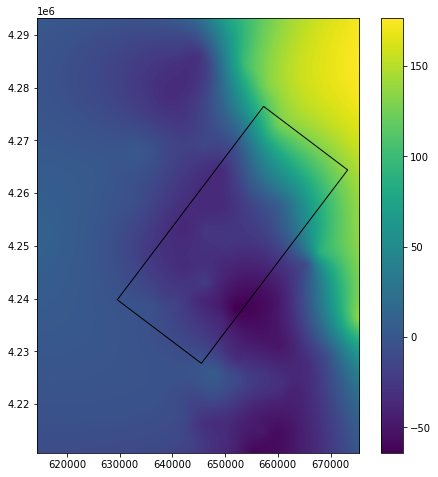

In [122]:
# ghb_dir = gwfm_dir+'/GHB_data'
# fig,ax= plt.subplots(figsize =(8,8))

# m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')

# ax = f2013_rio.plot(ax=ax)
# cbar = plt.colorbar(ax.images[0])

## Geostatus Guy - Professor Michael Pyrcz version based on Deutsch and Journel 1992

In [25]:
import geostatspy.GSLIB as GSLIB                          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats                    # GSLIB converted to Python


In [42]:
f2013['x'] = f2013.geometry.x
x = f2013.x
f2013['y'] = f2013.geometry.y
y = f2013.y

z = f2013.WSEL.values
gridx = np.arange(np.min(x), np.max(x), 200)
gridy = np.arange(np.min(y), np.max(y), 200)

In [44]:
xmin = f2013.x.min()
xmax = f2013.x.max()
ymin = f2013.y.min()
ymax = f2013.y.max()

cmap = plt.cm.plasma                    # color map
gw_min = f2013.WSEL.min()
gw_max = f2013.WSEL.max()

In [33]:
f2013.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well_Use,144.0,3.409722e+00,1.450407,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
Msmt_Agenc,144.0,2.985188e+03,2482.389194,1.000000e+00,1.000000e+00,5.022000e+03,5.022000e+03,5.203000e+03
WSEL,144.0,-1.516611e+01,40.220602,-6.998000e+01,-3.556500e+01,-2.625000e+01,-5.835000e+00,1.512100e+02
DGBS,144.0,8.931278e+01,45.561152,7.600000e+00,4.915000e+01,9.230000e+01,1.193500e+02,1.860000e+02
RP_Elevati,144.0,7.514847e+01,58.255344,6.500000e+00,3.274000e+01,6.075500e+01,1.058025e+02,3.144800e+02
GS_Elevati,144.0,7.414667e+01,58.141433,6.000000e+00,3.245250e+01,5.969000e+01,1.051000e+02,3.124800e+02
Msmt_Metho,144.0,1.208333e+00,0.407534,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
Msmt_Issue,144.0,6.875000e-01,2.398918,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
Latitude,144.0,3.833053e+01,0.216584,3.803230e+01,3.813705e+01,3.829060e+01,3.851597e+01,3.877554e+01
Longitude,144.0,-1.212970e+02,0.109842,-1.216916e+02,-1.213659e+02,-1.212891e+02,-1.212247e+02,-1.209949e+02


In [34]:
f2013['NWSEL'], tvWSEL, tnsWSEL = geostats.nscore(f2013, 'WSEL')

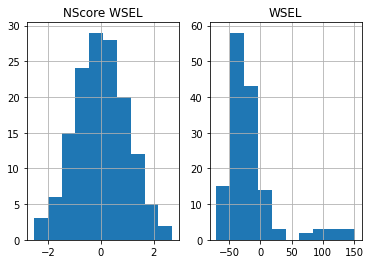

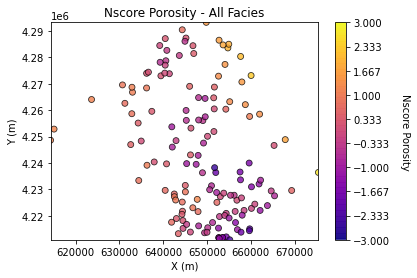

In [45]:
plt.subplot(121)
plt.title('NScore WSEL')
f2013.NWSEL.hist()
plt.subplot(122)
plt.title('WSEL')
f2013.WSEL.hist()
plt.show()

cmap = plt.cm.plasma                  
GSLIB.locmap_st(f2013,'x','y','NWSEL',xmin,xmax,ymin,ymax,-3,3,
                'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

In [72]:
# Calculate Sample Data Isotropic Variograms
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 100.0; nlag = 50; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, wsel_gamma, wsel_npair = geostats.gamv(f2013,"x","y","NWSEL",tmin,tmax,
                                                    lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

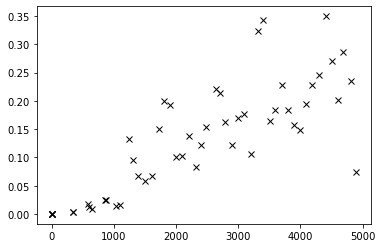

In [73]:
plt.plot(lag,wsel_gamma,'x',color = 'black',label = 'All')


In [28]:
xlen = xmax-xmin
ylen = ymax-ymin
xsiz = 100
ysiz = 100
nx = xlen/xsiz
ny = ylen/ysiz
nx = np.ceil(nx).astype(int)
ny = np.ceil(ny).astype(int)
if nx>ny:
    ny = nx
else:
    nx=ny
# readjust xmax, ymax based on nx, ny
xmax = xmin + xsiz*nx
ymax = ymin + ysiz*ny

tmin = -9999.9; tmax = 9999.9; 


In [29]:
xmin,xmax,ymin,ymax,xsiz

(614283.4123730734, 696783.4123730734, 4210874.85358532, 4293374.85358532, 100)

In [30]:
skmean_wsel = f2013.WSEL.mean()      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 10000                               # search radius for neighbouring data
nxdis = 100; nydis = 100                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate

wsel_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # wsel variogram

In [31]:
wsel_kmap, wsel_vmap = geostats.kb2d(f2013,'x','y','WSEL',tmin,tmax,nx,xmin,xsiz,ny,ymin,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_wsel,wsel_vario)

plt.subplot(211)
GSLIB.locpix_st(wsel_kmap,xmin,xmax,ymin,ymax,xsiz,-40,170,f2013,'x','y','WSEL','Kriging Estimate','X(m)','Y(m)','WSEL (m)',cmap)

plt.subplot(212)
GSLIB.pixelplt_st(wsel_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,'Kriging Variance','X(m)','Y(m)','WSEL $(m^2)$',cmap)

NameError: name 'real' is not defined